In [1]:
import csv
import json
from collections import Counter 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import load_data

# Load all the data of authors and papers:

In [2]:
authors_file = "data/corpus-subset-for-queries.authors.csv"
papers_file = "data/corpus-subset-for-queries.papers.csv"
authors_papers_file = "data/corpus-subset-for-queries.paper_authors.csv"
corpus_data_file = "data/corpus-subset-for-queries.jsonl"
training_data_file = 'data/TREC-Fair-Ranking-training-sample.json'

authors = load_data.load_authors(authors_file)
papers = load_data.load_papers(papers_file)
papers = load_data.load_papers_authors(authors_papers_file, papers)
papers = load_data.load_corpus(corpus_data_file, papers)
training_data = load_data.load_training_data(training_data_file)

# Create graph with citations

In [12]:
G_papers = nx.Graph()
G_authors = nx.Graph()
for key in papers.keys():
    for key2 in papers[key]['outCitations']:
        G_papers.add_edge(key, key2) 
    for key2 in papers[key]['inCitations']:
        G_papers.add_edge(key2, key) 
    if 'authors_order' not in papers[key]:
        papers[key]['authors_avg_citations'] = papers[key]['n_citations']
    else:
        for author1 in papers[key]['authors_order']:
            for author2 in papers[key]['authors_order']:
                if author1[0] != author2[0] and author2[0] != '' and author1[0] != '':
                    G_authors.add_edge(author1[0], author2[0]) 
        #print (papers[key]['authors_order'])
        papers[key]['authors_avg_citations'] = np.mean([int(authors[a[0]]['num_citations']) for a in papers[key]['authors_order'] if (a[0] in authors)])
        papers[key]['authors_avg_h_index'] = np.mean([int(authors[a[0]]['h_index']) for a in papers[key]['authors_order'] if (a[0] in authors)])

# Some Stats

In [4]:
print ("Number of authors:", len(authors))
print ("Max papers:", max([int(a['num_papers']) for a in authors.values()]))
print ("Max citations:", max([int(a['num_citations']) for a in authors.values()]))

Number of authors: 31975
Max papers: 10011
Max citations: 223684


In [5]:
print ("Number of papers:", len(papers))
print ("Min Year:", min([float(p['paper_year']) for p in papers.values() if p['paper_year'] != '']))
print ("Common venues:", Counter([p['venue'] for p in papers.values()]).most_common(10))

Number of papers: 8879
Min Year: 1824.0
Common venues: [('', 4601), ('ArXiv', 96), ('Nature', 59), ('The Lancet', 59), ('The New England journal of medicine', 53), ('Science', 44), ('medRxiv', 37), ('Proceedings of the National Academy of Sciences of the United States of America', 34), ('JAMA', 27), ('Sensors', 23)]


In [6]:
print ("Number of queries:", len(training_data))
print ("Common queries:", Counter([p['query'] for p in training_data]).most_common(10))

Number of queries: 200
Common queries: [('cloud computing', 1), ('constitutional law', 1), ('metalinguistic knowledge', 1), ('drogenzubereitung', 1), ('usefulness of debit card', 1), ('facilities management', 1), ('cloud computing in education', 1), ('consumer buying behaviour in branded and unbranded clothing', 1), ('python', 1), ('participatory culture', 1)]


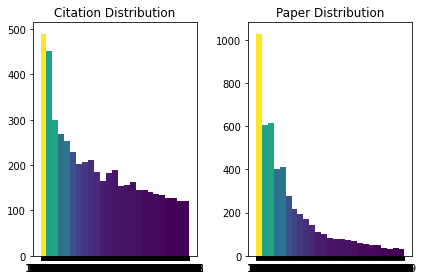

In [65]:
%matplotlib inline
from matplotlib import colors
import random

fig, axs = plt.subplots(1, 2, tight_layout=True)
n_bins = 25

#authors = dict(random.sample(authors.items(), 5000)) # Random Sampling
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

N, bins, patches = axs[0].hist([authors[x]["num_citations"] for x in authors] , bins=n_bins)
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

N, bins, patches = axs[1].hist([authors[x]["num_papers"] for x in authors] , bins=n_bins)
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs[0].title.set_text('Citation Distribution')
axs[1].title.set_text('Paper Distribution')

plt.show()


# Calculate the communities from the graph

In [41]:
import community as community_louvain
partion_papers = community_louvain.best_partition(G_papers)
partion_authors = community_louvain.best_partition(G_authors)

In [40]:
query_id = 0
print ("comunities of authors for the query:", training_data[query_id]['query'])
for d in training_data[query_id]['documents']:
    if d['doc_id'] in papers:
        curr_partition = set()
        for author in papers[d['doc_id']]['authors_order']:
            if author[0] in partion_authors:
                curr_partition.add(partion_authors[author[0]])
        print (list(curr_partition), d['relevance'])

comunities of authors for the query: cloud computing
[4209] 0
[1915] 0
[3428] 0
[1005] 0
[4127] 1
[1005] 0
[] 0
[3810] 0
[379] 0
[2391] 0
[1005] 0
[3969] 0
[2598] 0
[] 1
[4714] 0
[265] 0
[1518] 0
[2105] 0
[1005] 0
[1005] 0
[3645] 0
[83] 0
[3352] 0
[] 0
[3563] 0
[2027] 0
[1518] 0
[426] 0
[1380] 1
[2598] 0


In [39]:
query_id = 1
print ("comunities of papers for the query:", training_data[query_id]['query'])
for d in training_data[query_id]['documents']:
    if d['doc_id'] in partion:
        print (partion[d['doc_id']], d['relevance'])

comunities of papers for the query: constitutional law
46 0
43 0
43 0
25 0
109 0
45 0
109 1
43 0
68 0
46 0
109 0
46 0
52 0
45 0
49 1
45 0
109 0
25 0
22 0
43 0
18 1
45 0
109 1
109 0
43 0
109 0
46 0
539 0
43 1
109 0


TODO: look the relevant items in the queries and compute co-occurence of the communities. Then, use this information to rerank the results.